In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from keras.backend.tensorflow_backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam

/Users/adishrao/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [6]:
dataset_dir = 'eyes only'
label_dir_train = dataset_dir + '/train/labels/'
img_dir_train = dataset_dir + '/train/images/'
label_dir_validation = dataset_dir + '/validation/labels/'
img_dir_validation = dataset_dir + '/validation/images/'

In [7]:
labels_train = sorted(os.listdir(label_dir_train))
images_train = sorted(os.listdir(img_dir_train))

labels_validation = sorted(os.listdir(label_dir_validation))
images_validation = sorted(os.listdir(img_dir_validation))


# mac specific .DS_STORE 
if images_train[0] == '.DS_Store':
    images_train.remove('.DS_Store')
if images_validation[0] == '.DS_Store':
    images_validation.remove('.DS_Store')
if labels_train[0] == '.npy':
    labels_train.pop(0)
if labels_validation[0] == '.npy':
    labels_validation.pop(0)

In [8]:
width, height = 32, 32
nc = 2
DATASIZE = 400

X_train = []
Y_train = []
X_val = []
Y_val = []
ik=0


for img_path, lbl_path in list(zip(images_train,labels_train))[:DATASIZE]:
    if img_path[:12] != lbl_path[:12]:
        print('ERROR. Check folder organisation')
        break
        
for img_path, lbl_path in list(zip(images_validation,labels_validation))[:DATASIZE]:
    if img_path[:12] != lbl_path[:12]:
        print('ERROR. Check folder organisation')
        break

for img_path, lbl_path in list(zip(images_train,labels_train))[:]:
    try:
        # load image and label, resize, append
        img = cv2.imread(img_dir_train + img_path)
        img = np.float32(img) / 255 # - 1 #averagin values. sohuld we remove?
        X_train.append(img)

        lbl = np.load(label_dir_train + lbl_path)
        seg = np.zeros((  height , width  , nc ))
        for c in range(nc):
            seg[:, :, c] = (lbl==c).astype(int)
        Y_train.append(seg)
    except Exception as e: 
        print(e)
        print(img_path,lbl_path)
        ik+=1
print("i",ik)
X_train, Y_train = np.array(X_train) , np.array(Y_train)
ik = 0
for img_path, lbl_path in list(zip(images_validation,labels_validation))[:]:
    try:
        # load image and label, resize, append
        img = cv2.imread(img_dir_validation + img_path)
        img = np.float32(img) / 255 # - 1 #averagin values. sohuld we remove?
        X_val.append(img)

        lbl = np.load(label_dir_validation + lbl_path)
        seg = np.zeros((  height , width  , nc ))
        for c in range(nc):
            seg[:, :, c] = (lbl==c).astype(int)
        Y_val.append(seg)
    except Exception as e: 
        print(e)
        print(img_path,lbl_path)
        ik+=1
print("i",ik)
X_val, Y_val = np.array(X_val) , np.array(Y_val)

i 0
i 0


In [27]:
img_input = Input(shape=(32,32 , 3 ))

#encode
conv1 = Conv2D(32, (3,3), activation='relu', padding='same')(img_input)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(32, (1, 1), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2))(conv2)

#decode
conv3 = Conv2D(256, (1, 1), activation='relu', padding='same')(pool2)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(32, (1, 1), activation='relu', padding='same')(up1)

conv4 = Add()([conv4, conv2]) # SKIP Connection

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)

conv5 = Add()([conv5_1, conv1]) # SKIP Connection

out = Conv2D( 2, (1, 1) , padding='same')(conv5)
o = (Activation('softmax'))(out)

model = Model(img_input, o)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 32)   896         input_10[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 16, 16, 32)   1056        max_pooling2d_15[0][0]           
__________________________________________________________________________________________________
max_poolin

In [30]:
from keras.models import load_model
model = load_model('eyes_only_temp_1.h5')

In [31]:
from keras import optimizers

sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [20]:
hist1 = model.fit(X_train,Y_train,
                  validation_data=(X_val,Y_val),
                  batch_size=32,epochs=10,verbose=1)
model.save('eyes_only_temp_1.h5')
#98.86

#98.83

#98.37

Train on 8916 samples, validate on 2403 samples
Epoch 1/23
8916/8916 [==============================] - 103s 12ms/step - loss: 0.0355 - acc: 0.9863 - val_loss: 0.0465 - val_acc: 0.9826
Epoch 2/23
8916/8916 [==============================] - 107s 12ms/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0465 - val_acc: 0.9828
Epoch 3/23
8916/8916 [==============================] - 106s 12ms/step - loss: 0.0351 - acc: 0.9864 - val_loss: 0.0478 - val_acc: 0.9824
Epoch 4/23
8916/8916 [==============================] - 107s 12ms/step - loss: 0.0347 - acc: 0.9866 - val_loss: 0.0477 - val_acc: 0.9825
Epoch 5/23
8916/8916 [==============================] - 105s 12ms/step - loss: 0.0355 - acc: 0.9863 - val_loss: 0.0489 - val_acc: 0.9817
Epoch 6/23
8916/8916 [==============================] - 106s 12ms/step - loss: 0.0351 - acc: 0.9864 - val_loss: 0.0475 - val_acc: 0.9823
Epoch 7/23
8916/8916 [==============================] - 106s 12ms/step - loss: 0.0348 - acc: 0.9865 - val_loss: 0.0475 - val_acc: 

In [29]:
model.count_params()

38178

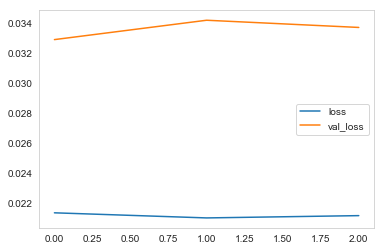

In [18]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [21]:
y_pred = model.predict(X_val)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(Y_val, axis=3)

In [22]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=2105940, #FP= 17573, #FN=28098, IoU=0.979
class 01: #TP=309061, #FP= 28098, #FN=17573, IoU=0.871
_________________
Mean IoU: 0.925


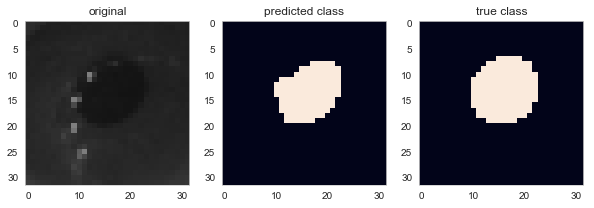

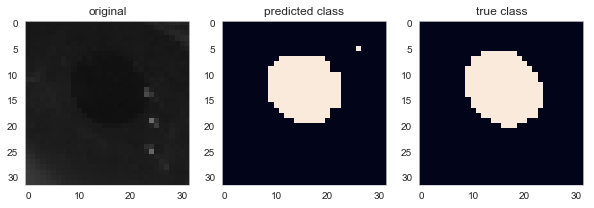

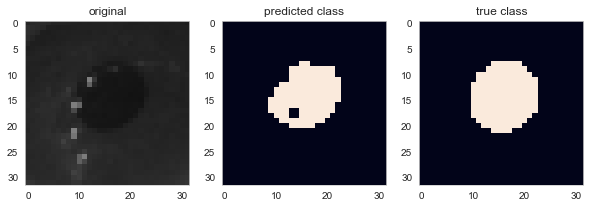

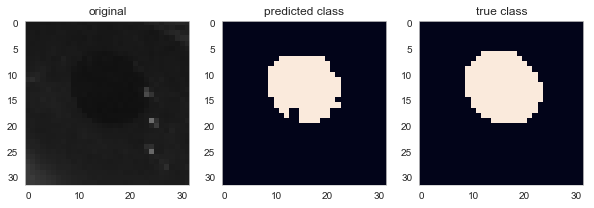

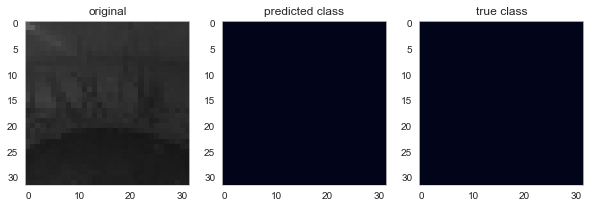

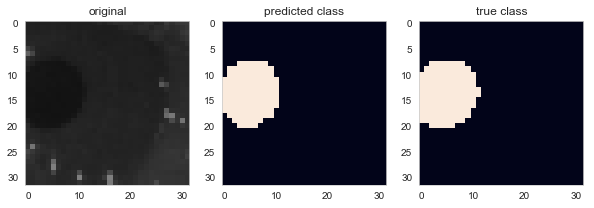

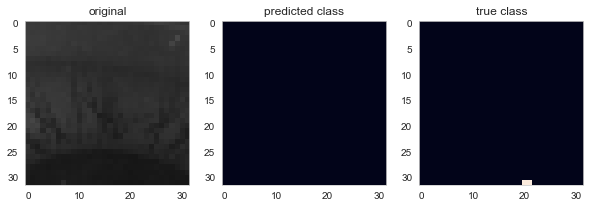

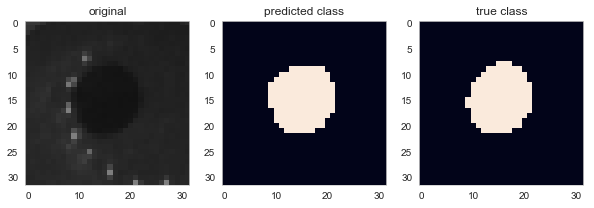

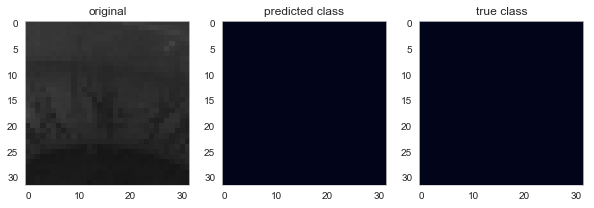

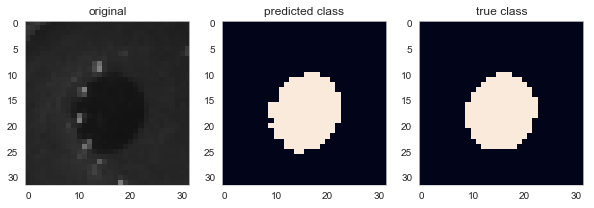

In [19]:
shape = (32,32)
n_classes= 2

for i in range(10):
    img_is  = (X_val[i])*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(seg)
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(segtest)
    ax.set_title("true class")